# The LOTlib3 library - continued

> __**NOTE**__ This is based on Piantadosi's introduction to LOTlib3, which you can find [here](https://github.com/piantado/LOTlib3/blob/master/Documentation/Tutorial.md).

In [1]:
try:
    # in colab
    import google.colab
    print('In colab, downloading LOTlib3')
    !git clone https://github.com/thelogicalgrammar/LOTlib3
except:
    # not in colab
    print('Not in colab!')

Not in colab!


In [149]:
from LOTlib3.Grammar import Grammar
from LOTlib3.Hypotheses.LOTHypothesis import LOTHypothesis
from math import log, exp
from LOTlib3.DataAndObjects import FunctionData
from LOTlib3.Samplers.MetropolisHastings import MetropolisHastingsSampler
from collections import Counter
from LOTlib3.Miscellaneous import logsumexp
import numpy as np
import matplotlib.pyplot as plt

## Primitives

In the last lab, we have seen how to define custom interpreted operations in our LOTlib3 (interpreted) grammars: we can use arbitrary Python in the function argument. However, there are two more ways to make this more convenient when you need more complex interpretations: built-in LOTlib3 operations and your own custom operations. Let's look at them in turn.

### Builtin LOTlib3 operations

LOTlib3 defines a number of primitive operations (you can find them in `LOTlib3.Primitives`). When these are supplied as the `<FUNCTION>` in grammar rule, they act as functions that get called. **By convention, LOTlib3 internal primitives end in an underscore**. Here is an example equivalent to the grammar from last week, but using LOTlib3 function calls:

In [71]:
def produce_grammar(numerals_weight=10):
    
    grammar = Grammar(start='EXPR')
    
    grammar.add_rule(
        'EXPR', 
        'plus_', 
        ['EXPR', 'EXPR'], 
        1.0
    )
    
    grammar.add_rule(
        'EXPR', 
        'times_', 
        ['EXPR', 'EXPR'], 
        1.0
    )
    
    grammar.add_rule(
        'EXPR', 
        'divide_(float(%s),float(%s))', 
        ['EXPR', 'EXPR'], 
        1.0
    )
    
    grammar.add_rule(
        'EXPR', 
        'neg_', 
        ['EXPR'], 
        1.0
    )
    
    for n in range(1,10):
        grammar.add_rule('EXPR', str(n), None, numerals_weight/(n**2))

    return grammar

In [72]:
grammar = produce_grammar(10)

Note that when these are rendered into strings, they appear as function calls (and not just string substitutions to make python code) as in:

```
times_(plus_(x,neg_(1)), plus_(1,1))
```

There are many functions built-in to python, including a number of operations for manipulating sets, numbers, and logic. The code for `divide_` shows that it does not cast its arguments to floats: here we have to do so using string substitution as above.  For simple thing it is up to you to decide if you like to use the built in python operators (e.g. '+') or the LOTLib3 primitive ('plus_') as they are basically the same.

### Custom operations

You can also create new primitives which extends the functionality of LOTlib3 in many interesting way. Unfortunately, if you just define a new function in the script, you cannot directly use it in the grammar. Let's try, first defining the primitive as a regular function and then adding it as part of a rule:

In [74]:
def my_silly_primitive(x):
    return x+222

grammar = produce_grammar(2)
grammar.add_rule('EXPR', 'my_silly_primitive_', ['EXPR'], 1.0)

EXPR -> my_silly_primitive_['EXPR']	w/ p=1.0

Let's make sure that the rule was added:

In [75]:
grammar.display_rules()

EXPR -> plus_['EXPR', 'EXPR']	w/ p=1.0
EXPR -> times_['EXPR', 'EXPR']	w/ p=1.0
EXPR -> divide_(float(%s),float(%s))['EXPR', 'EXPR']	w/ p=1.0
EXPR -> neg_['EXPR']	w/ p=1.0
EXPR -> 1	w/ p=2.0
EXPR -> 2	w/ p=0.5
EXPR -> 3	w/ p=0.2222222222222222
EXPR -> 4	w/ p=0.125
EXPR -> 5	w/ p=0.08
EXPR -> 6	w/ p=0.05555555555555555
EXPR -> 7	w/ p=0.04081632653061224
EXPR -> 8	w/ p=0.03125
EXPR -> 9	w/ p=0.024691358024691357
EXPR -> my_silly_primitive_['EXPR']	w/ p=1.0


And now let's try to interpret:

We can then generate new rules until we find something that contains `my_silly_primitive`:

In [83]:
generation = grammar.
print(generation)

neg_(my_silly_primitive_(divide_(float(neg_(divide_(float(neg_(2)),float(1)))),float(1))))


And now, if we initialize a hypothesis with our generation and then try to call it, it will raise a NameError:

In [92]:
h = LOTHypothesis(
    grammar=grammar,
    value=generation,
    display="lambda: %s"
)

try:
    h()
except NameError as e:
    print(e)

NameError in function call:  name 'my_silly_primitive_' is not defined  ;  lambda: neg_(my_silly_primitive_(divide_(float(neg_(divide_(float(neg_(2)),float(1)))),float(1)))) ()



To make a custom function accessible to LOTlib3's evaluator, use the `@primitive` decorator:

In [93]:
from LOTlib3.Eval import primitive

@primitive
def my_silly_primitive_(x):
    return x+222

Now if you use `my_stupid_primitive_` in a grammar rule, it can be "run" just like any normal python code

In [94]:
grammar = produce_grammar()
grammar.add_rule('EXPR', 'my_silly_primitive_', ['EXPR'], 1.0)

EXPR -> my_silly_primitive_['EXPR']	w/ p=1.0

In [95]:
grammar.display_rules()

EXPR -> plus_['EXPR', 'EXPR']	w/ p=1.0
EXPR -> times_['EXPR', 'EXPR']	w/ p=1.0
EXPR -> divide_(float(%s),float(%s))['EXPR', 'EXPR']	w/ p=1.0
EXPR -> neg_['EXPR']	w/ p=1.0
EXPR -> 1	w/ p=10.0
EXPR -> 2	w/ p=2.5
EXPR -> 3	w/ p=1.1111111111111112
EXPR -> 4	w/ p=0.625
EXPR -> 5	w/ p=0.4
EXPR -> 6	w/ p=0.2777777777777778
EXPR -> 7	w/ p=0.20408163265306123
EXPR -> 8	w/ p=0.15625
EXPR -> 9	w/ p=0.12345679012345678
EXPR -> my_silly_primitive_['EXPR']	w/ p=1.0


It is generally more friendly to give it an underscore to make sure it's not confused for a normal python function.

## Nonterminals in the grammar

Up to this point, our grammar only contained a single non-terminal symbol, `EXPR`, representing a number. But what if we have more than one kind of expression, e.g., numbers _and_ booleans? LOTlib3 can deal with this easily with the arguments to `grammar.add_rule` we saw in the last lab. Recall from last week that these are its arguments:
```python
grammar.add_rule( <NONTERMINAL>, <FUNCTION>, <ARGUMENTS>, <PROBABILITY>)
```

Here's how it works:

- The `<NONTERMINAL>` part of each grammar rule can be viewed as specifying the *return type* of the function that rule correspond to. For instance, if the rule outputs something of numerical type, this would be `EXPR`, and it the rule outputs something of boolean type, we could call it `BOOL`.
- The `<ARGUMENTS>` can be viewed as the types of the *input arguments*.

Thus, what a grammar mainly does is ensure that the primitives all get arguments of the correct types. Let's see this in action: suppose we had two kinds of things: booleans (BOOL) and numbers (EXPR). We might write a grammar like this:

In [105]:
grammar = Grammar(start='EXPR')

grammar.add_rule('EXPR', 'plus_', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', 'times_', ['EXPR', 'EXPR'], 1.0)

# Use something that renders into if statements in real python
grammar.add_rule('EXPR', '(%s if %s else %s)', ['EXPR', 'BOOL', 'EXPR'], 1.0)

# Now how do we get a boolean?
grammar.add_rule('BOOL', '(%s > %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('BOOL', '(%s >= %s)', ['EXPR', 'EXPR'], 1.0)

# And a terminal
grammar.add_rule('EXPR', '1', None, 4.0)
grammar.add_rule('EXPR', '2', None, 4.0)

EXPR -> 2	w/ p=4.0

Here, the second argument to the `if` line must be a `BOOL`, and so we have given LOTlib3 a way to create code that returns `BOOL`s. It just happens that this code is a comparison of numbers, or `EXPR`s. Let's look at some generations:

In [106]:
for i in range(10):
    print(grammar.generate())

1
1
plus_((1 if (1 >= times_((2 if (2 > 2) else times_(2, 1)), 2)) else 2), 2)
times_(times_(2, 1), 2)
1
plus_(1, 2)
2
2
2
2


## The best hypotheses

Now let's go back to how we can store the results of the inference. First, let's define the Grammar and Hypothesis again:

In [110]:
grammar = produce_grammar(10)

# define a hypothesis
class MyHypothesis(LOTHypothesis):
    
    def __init__(self, **kwargs):
        LOTHypothesis.__init__(
            self, 
            grammar=grammar, 
            display="lambda: %s", 
            **kwargs
        )

    def compute_single_likelihood(self, datum):
        """Define the loglikelihood function P(datum | self)"""
        prob_of_random_number = (1.0-datum.alpha)/100.
        if self(*datum.input) == datum.output:
            return log(prob_of_random_number + datum.alpha)
        else:
            return log(prob_of_random_number) 

data = [ 
    FunctionData(
        input=[], 
        output=12, 
        alpha=0.999
    ) 
]

Very often, models in LOTlib3 approximate the full posterior distribution $P(H|D)$ using the highest posterior hypotheses. There are two main ways to do this. One is a class named `LOTlib3.TopN` which acts like a set--you can add to it, but it keeps only the ones with highest `posterior_score` (or whatever "key" is set). It will return them to you in a sorted order:

In [ ]:
from LOTlib3.TopN import TopN

# store the top N
tn = TopN(N=10)
h0 = MyHypothesis()
for h in MetropolisHastingsSampler(h0, data, steps=10000):
    tn.add(h)

We can see the best formulas as follows:

In [116]:
for h in tn.get_all(sorted=True):
    print(h.posterior_score, h, h())

-12.888815174461108 lambda: times_(times_(4, 1), 3) 12
-12.888815174461108 lambda: times_(divide_(float(4),float(1)), 3) 12.0
-12.888815174461108 lambda: times_(4, times_(1, 3)) 12
-12.888815174461108 lambda: times_(plus_(2, 2), 3) 12
-12.313451029557548 lambda: times_(plus_(1, 3), 3) 12
-12.313451029557548 lambda: times_(plus_(3, 1), 3) 12
-12.175493704674896 lambda: 1 1
-12.07788495824478 lambda: times_(4, plus_(1, 2)) 12
-12.07788495824478 lambda: times_(4, plus_(2, 1)) 12
-9.261093602057727 lambda: times_(4, 3) 12


There's also a friendly way to interface with `TopN`:

In [112]:
for h in MetropolisHastingsSampler(h0, data, steps=10000):
    tn << h

In [121]:
for h in tn.get_all(sorted=True):
    print(h.posterior_score, h, h())

-12.888815174461108 lambda: times_(times_(4, 1), 3) 12
-12.888815174461108 lambda: times_(divide_(float(4),float(1)), 3) 12.0
-12.888815174461108 lambda: times_(4, times_(1, 3)) 12
-12.888815174461108 lambda: times_(plus_(2, 2), 3) 12
-12.313451029557548 lambda: times_(plus_(1, 3), 3) 12
-12.313451029557548 lambda: times_(plus_(3, 1), 3) 12
-12.175493704674896 lambda: 1 1
-12.07788495824478 lambda: times_(4, plus_(1, 2)) 12
-12.07788495824478 lambda: times_(4, plus_(2, 1)) 12
-9.261093602057727 lambda: times_(4, 3) 12


Productions the results in the output 12 have high posterior scores and are in general among the best hypotheses.  However, some very simple and short programs like a single number output (like 0) might still appear among the "top" hypotheses. This is because the prior might make them still quite likely given the specified level of noise $\alpha$, i.e., the observation might have been a mistake. This shows the importance of thinking about the nature of your prior and the likelihood function for your problem.

## Hypotheses as functions

When we defined MyHypothesis, we passed `display="lambda: %s"` to `LOTHypothesis.__init__`. That meant that a hypothesis was not a function of any arguments, since the `lambda` has no arguments. You may have noticed that when a hypothesis is converting to a string (for printing or evaling) it acquires this additional `lambda` on the outside, indicating that the hypothesis was a function of no arguments, or a [thunk](https://en.wikipedia.org/wiki/Thunk). 

However, often we want our hypotheses to be a function with arguments! Then, our observations can be sets of (input, output) tuples, and the hypothesis can be a function that given each input returns each output. Let's define a new grammar that allows us to encode functions, and a corresponding MyHypothesis that requires an argument. 

In [122]:
grammar = Grammar(start='EXPR')

grammar.add_rule('EXPR', '(%s + %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(%s * %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(float(%s) / float(%s))', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(-%s)', ['EXPR'], 1.0)

# Now define how the grammar uses x. The string 'x' must
# be the same as used in the args below.
# Basically, x will now sometimes appear in the formulas,
# and in those cases it can be bound in Hypothesis.
grammar.add_rule('EXPR', 'x', None, 1.0) 

for n in range(0,10):
    grammar.add_rule('EXPR', str(n), None, 10.0/((n+1)**2))

Let's define the Hypothesis:

In [143]:
class MyHypothesisX(LOTHypothesis):
    def __init__(self, **kwargs):
        LOTHypothesis.__init__(
            self, 
            grammar=grammar, 
            # NOTE: now we pass an argument
            # to the lambda function
            display="lambda x: %s", 
            **kwargs
        )

    def __call__(self, *args):
        try:
            # try to do it from the superclass
            return LOTHypothesis.__call__(self, *args)
        except ZeroDivisionError:
            # and if we get an error, return nan
            return float("nan")

    def compute_single_likelihood(self, datum):
        call_output = self(*datum.input)
        if call_output == 'nan':
            return -float('inf')
        elif call_output == datum.output:
            return log((1.0-datum.alpha)/100. + datum.alpha)
        else:
            return log((1.0-datum.alpha)/100.)

Now, when the hypothesis renders, it comes with a `lambda x` in front, rather than just a `lambda`. The grammar now has to allow the argument (`x`) to be produced in expressions.

We also define the `datum.input` so that it has an input, which gets bound to `x` when the function is evaluated:

In [134]:
# Now our data takes input x=3 and maps it to 12
# What could the function be?
data = [ 
    FunctionData(
        input=[3], 
        output=12, 
        alpha=0.99
    ) 
]

Let's actually run this and see what it comes up with:

In [135]:
tn = TopN(N=10) 
h0 = MyHypothesisX()

for h in MetropolisHastingsSampler(h0, data, steps=100000):
    tn << h

In [136]:
for h in tn.get_all(sorted=True):
    print(h.posterior_score, h)

-11.84347278665917 lambda x: (9 + 3)
-11.373469157413435 lambda x: (9 + x)
-11.373469157413435 lambda x: (x + 9)
-11.314361217957266 lambda x: 1
-10.554758753878144 lambda x: (2 * 6)
-10.457178425539281 lambda x: (4 * 3)
-10.457178425539281 lambda x: (3 * 4)
-9.987174796293544 lambda x: (x * 4)
-9.987174796293544 lambda x: (4 * x)
-9.928066856837376 lambda x: 0


Why does this matter? Well now instead of just explaining the data we saw, we can use the hypothesis to generalize to *new*, unseen data. For instance, we can take each hypothesis and see what it has to say about other numbers

In [137]:
# For each top N hypothesis, we'll see what it maps 0..9 to 
for h in tn.get_all(sorted=True):
    print(h.posterior_score, h, list(map(h, range(0,10))))

-11.84347278665917 lambda x: (9 + 3) [12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
-11.373469157413435 lambda x: (9 + x) [9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
-11.373469157413435 lambda x: (x + 9) [9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
-11.314361217957266 lambda x: 1 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
-10.554758753878144 lambda x: (2 * 6) [12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
-10.457178425539281 lambda x: (4 * 3) [12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
-10.457178425539281 lambda x: (3 * 4) [12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
-9.987174796293544 lambda x: (x * 4) [0, 4, 8, 12, 16, 20, 24, 28, 32, 36]
-9.987174796293544 lambda x: (4 * x) [0, 4, 8, 12, 16, 20, 24, 28, 32, 36]
-9.928066856837376 lambda x: 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Thus, we have taken a single data point and used it to infer a function that can *generalize* to new, unseen data or arguments. Note, though, that there is no requirement that `x` is used in each hypothesis. (If we wanted that, a LOTlib3ian way to do it would be to modify the prior to assign trees that don't use `x` to have `-Infinity` log prior). 

Just for fun here, let's take the posterior predictive and see how likely we are to generalize this function to every other number. 

In [144]:
tn = TopN(1000) 

h0 = MyHypothesisX()
for h in MetropolisHastingsSampler(h0, data, steps=100000):
    tn.add(h)

# store these in a list (tn.get_all is defaultly a generator)
hypotheses = list(tn.get_all())

In [ ]:
# Compute the normalizing constant
z = logsumexp([h.posterior_score for h in hypotheses])

# Now compute a matrix of how likely each input is to go
# to each output.
# An MxM matrix of values
M = 20

# The probability of generalizing
G = np.zeros((M,M))

# Now add in each hypothesis' predictive
for h in hypotheses:
    # the (normalized) posterior probability of this hypothesis
    p = np.exp(h.posterior_score - z)

    for x in range(M):
        try:
            output = int(h(x))
        except ValueError:
            continue

        # only keep those that are in the right range
        if 0 <= output < M:
            G[x][int(output)] += p

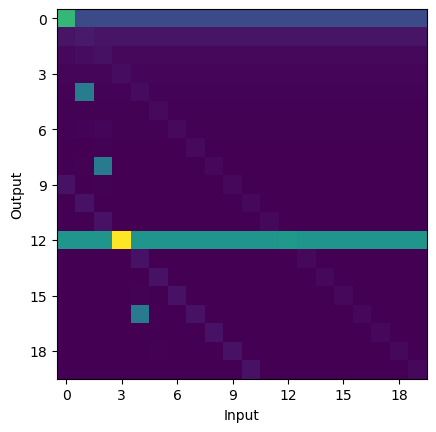

In [160]:
# And show the output
plt.imshow(np.array(G).T)
plt.xticks(np.arange(0,20,3))
plt.yticks(np.arange(0,20,3))
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

As you can see from the complexity of this array which shows the probabilities for different outputs given different inputs, observing that some (unseen) function maps 3->12 gives rise to nontrivial beliefs about the function underlying this transformation. 

## Lambdas

The power of this kind of representation comes not only from an ability to learn such simple functions, but to also learn functions with new kinds of abstractions. In programming languages, the simplest kind of abstraction is a variable--a value that is stored for later use. The variable `x` is created above on the level of a LOTHypothesis, but where things get more interesting is when the lower down values in a grammar can be used to define variables. Let's look at a grammar with two additional pieces

In [ ]:
from LOTlib3.Grammar import Grammar
grammar = Grammar(start='EXPR')

grammar.add_rule('EXPR', '(%s + %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(%s * %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(float(%s) / float(%s))', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(-%s)', ['EXPR'], 1.0)

grammar.add_rule('EXPR', 'x', None, 1.0) 

for n in range(1,10):
    # We'll make these lower probability so we can see more lambdas below
    grammar.add_rule('EXPR', str(n), None, 5.0/n**2)

In [ ]:
# And allow lambda abstraction
# First we define the application of a new nonterminal, FUNC, to a term EXPR
grammar.add_rule('EXPR', '(%s)(%s)', ['FUNC', 'EXPR'], 1.0)
# Here, FUNC should be thought of as a function
grammar.add_rule('FUNC', 'lambda', ['EXPR'], 1.0, bv_type='EXPR')

Here, `lambda` is a special LOTlib3 keyword that *introduces a bound variable* with a unique name in expanding the <ARGUMENT>s. In other words, when the grammar happens to sample a rule whose <FUNCTION> is `'lambda'`, it creates a new variable name, allows `bv_type` to expand to this variable, expands the <ARGUMENTS> to `lambda` (here, `EXPR`), and then removes the rule from the grammar. Let's look at some productions:

In [ ]:
for _ in range(1000):
    print(grammar.generate())

Now some of the trees contain `lambda` expressions, which bind a variable (defaultly rendered as `y1`). The variable `y1` can only be used below its corresponding lambda, making the grammar in LOTlib3 technically not context-free, but very weakly context-sensitive. The variables like `y1` are called **bound variables** in LOTlib3. Note that they are numbered by their height in the tree, making them unique to the nodes below, but neither sequential, nor unique in the whole tree (underlyingly, they have unique names no matter what, but not when rendered into strings). 

These bound variables count towards the prior (when using `grammar.log_probability`) in exactly the way they should: when a nonterminal (specified in `bv_type`) can expand to a given bound variable, that costs probability, and other expansions must lose probability. The default in LOTlib3 is to always renormalize the probabilities specified. Note that in the `add_rule` command, we can change the probability that a EXPR->yi rule has by passing in a bv_p argument:

In [ ]:
# make using yi 10x more likely than before
grammar.add_rule('FUNC', 'lambda', ['EXPR'], 1.0, bv_type='EXPR', bv_p=10.0)

Lambdas like these play the role of variable declarations in a normal programming language. But note that the variables aren't guaranteed to be useful. In fact, very often variables are stupid, as in the expression

In [ ]:
(lambda y1: y1)((1 * 1))

where the lambda defines a variable that is used immediately without modification. This expression is therefore equivalent to 

In [ ]:
(1 * 1)

in terms of its function, but not in terms of its prior. 

We can also change the name that bound variables get by setting `bv_prefix`:

In [ ]:
grammar.add_rule('FUNC', 'lambda', ['EXPR'], 1.0, bv_type='EXPR', bv_prefix='v')

will make bound variables named `v1`, `v2`, etc. 

## Here's where things get crazy

Of course, the true art of lambdas is not just that they can define variables, but that the variables themselves can be functions! This corresponds to *function declarations* in ordinary programming languages. If this is foreign or weird, I'd suggest reading [The Structure and Interpretation of Computer Programs](https://mitpress.mit.edu/sicp/). 

To define lambdas as functions, we only need to specify a `bv_args` list in the `lambda` declaration. `bv_args` is the type of arguments that are passed to each use of a bound variable each time it is used. But... then we have a problem of needing to bind that variable to something. If `yi` is itself a function of an EXPR, then its argument *also* has to be a function. That requires two lambdas. Here's how it works:

In [ ]:
from LOTlib3.Grammar import Grammar
grammar = Grammar(start='EXPR')

grammar.add_rule('EXPR', '(%s + %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(%s * %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(float(%s) / float(%s))', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(-%s)', ['EXPR'], 1.0)

grammar.add_rule('EXPR', 'x', None, 1.0)  

for n in xrange(1,10):
    grammar.add_rule('EXPR', str(n), None, 5.0/n**2)

# Allow ourselves to define functions. This means creating a bound 
# variable that can be bound to a FUNC. Where, the bound variable
# is defined (here, FUNCDEF) we are allowed to use it. 
grammar.add_rule('EXPR', '((%s)(%s))',  ['FUNCDEF', 'FUNC'], 1.0)

# The function definition has a bound variable who can be applied as
# a function, whose arguments are an EXPR (set by the type of the FUNC above)
# and whose name is F, and who when applied to an EXPR returns an EXPR
# We'll also set bv_p here. Feel free to play with it and see what that does. 
grammar.add_rule('FUNCDEF', 'lambda', ['EXPR'], 1.0, bv_type='EXPR', bv_args=['EXPR'], bv_prefix='F')

# and we have to say what a FUNC is. It's a function (lambda) from an EXPR to an EXPR
grammar.add_rule('FUNC', 'lambda', ['EXPR'], 1.0, bv_type='EXPR')

Let's look at some hypotheses. Here, we'll show only those that use `F1` as a function (thus contain the string `"F1("`):

In [ ]:
import re 

for _ in xrange(50000):
    t = grammar.generate()
    if re.search(r"F1\(", str(t)):
        print t

For instance, this code might generate the following expression, which is obscure, though acceptable, python:

```
((lambda F1: F1(x+1))(lambda y1: y1+3))
```

Here, we have define a variable `F1` that really represents the *function* `lambda y1: y1+3`. The value that is returned is the value of applying `F1` to the overall hypothesis value `x` plus `1`. Note that LOTlib3 here has correctly used `F1` in a context where an EXPR is needed (due to `bv_type='EXPR'` on `FUNCDEF`). It knows that the argument to `F1` is also an EXPR, which here happens to be expanded to `x+1`. It also knows that `F1` is itself a function, and it binds this function (through the outermost apply) to `lambda y1: y1+3`. LOTlib3 knows that `F1` can only be used in the left hand side of this apply, and `y1` can only be used on the right. This holds even if multiple bound variables of different types are generated. 

This ability to define functions provides some of the most interesting learning dynamics for the model. A nice example is provided in LOTlib3.Examples.Magnetism, where learners take data and learn predicates classifying observable objects into two kinds, as well as laws stated over those kinds.

## Recursive functions

Well that's wonderful, but what if we want a function to refer to *itself*? This is common in programming languages in the form of [recursive](https://en.wikipedia.org/wiki/Recursion_%28computer_science%29) definitions. This takes a little finagling in the LOTlib3 internals (through ambitious use of the [Y-combinator](https://en.wikipedia.org/wiki/Fixed-point_combinator#Fixed_point_combinators_in_lambda_calculus)) which you don't have to worry about. There is a class that implements recursion straightforwardly: `RecursiveLOTHypothesis`. Internally, hypothesis of this type always have an argument (defaultly called `recurse_`) which binds to themselves! 

Here is a simple example:

In [ ]:
######################################## 
## Define the grammar
######################################## 

from LOTlib3.Grammar import Grammar
grammar = Grammar(start='EXPR')

# for simplicity, two operations
grammar.add_rule('EXPR', '(%s + %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(%s * %s)', ['EXPR', 'EXPR'], 1.0)

# we'll just allow two terminals for simplicity
# We have to upweight them a little to keep things well-defined
grammar.add_rule('EXPR', 'x', None, 10.0) 
grammar.add_rule('EXPR', '1', None, 10.0) 

# If we're going to allow recursion, we better have a base case
# But this probably requires an "if" statement. LOTlib3's "if_" 
# primitive will do the trick
grammar.add_rule('EXPR', '(%s if %s else %s)', ['EXPR', 'BOOL', 'EXPR'], 1.0)

# and we need to define a boolean. For now, let's just check
# if x=1
grammar.add_rule('BOOL', 'x==1', None, 1.0)

# and the recursive operation -- I am myself a function
# from EXPR to EXPR, so recurse should be as well
grammar.add_rule('EXPR', 'recurse_', ['x-1'], 1.0) 

######################################## 
## Define the hypothesis
######################################## 
from LOTlib3.Hypotheses.RecursiveLOTHypothesis import RecursiveLOTHypothesis

class MyRecursiveHypothesis(RecursiveLOTHypothesis):
    def __init__(self, **kwargs):
        RecursiveLOTHypothesis.__init__(self, grammar=grammar, display="lambda recurse_, x: %s", **kwargs)

######################################## 
## Look at some examples
######################################## 
import re
from LOTlib3.Eval import RecursionDepthException

for _ in range(50000):
    h = MyRecursiveHypothesis()

    # Now when we call h, something funny may happen: we may get
    # an exception for recursing too deep. If this happens for some 
    # reasonable xes, let's not print the hypothesis -- it must not 
    # be well-defined
    try:
        # try our function out
        values = map(h, range(1,10))
    except RecursionDepthException:
        continue

    # if we succeed, let's only show hypotheses that use recurse:
    if re.search(r"recurse_\(", str(h)):
        print(h) 
        print(values)

Note that there is nothing special about the `recurse_` name: it can be changed by setting `recurse=...` in `RecursiveLOTHypothesis.__init__`, but then the name should also be changed in the grammar. In this tutorial, we have only looked at defining the grammar, not in inferring recursive hypotheses. LOTlib3.Examples.Number is an example of learning a genuinely recursive function from data. 